## Imports

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from fastai.models.senet import *
from skimage.transform import resize
import json
from sklearn.model_selection import train_test_split, StratifiedKFold , KFold
from sklearn.metrics import jaccard_similarity_score
from pycocotools import mask as cocomask
from utils import my_eval,intersection_over_union_thresholds,RLenc
from lovasz_losses import lovasz_hinge
print(torch.__version__)
torch.cuda.is_available()
torch.backends.cudnn.benchmark=True

## Paths

In [2]:
PATH = Path('data/tgs/')
TRN_MASKS = 'trn_masks'
TRN_IMG = 'trn_images'
TRN_MSK = 'trn_masks'
TST_IMG = 'tst_images'
trn = pd.read_csv(PATH/'train.csv')
dpth = pd.read_csv(PATH/'depths.csv')

In [3]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

## Datasets

In [4]:
class DepthDataset(Dataset):
    def __init__(self,ds,dpth_dict):
        self.dpth = dpth_dict
        self.ds = ds
        
    def __getitem__(self,i):
        val = self.ds[i]
        return val[0],self.dpth[self.ds.fnames[i].split('/')[1][:-4]],val[1]
    
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
        
    def get_x(self, i): 
        return open_image(os.path.join(self.path, self.fnames[i]))
    
    def get_y(self, i):
        return open_image(os.path.join(str(self.path), str(self.y[i])))

    def get_c(self): return 0
    
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform,flip, path):
        self.y=y
        self.flip = flip
        super().__init__(fnames, transform, path)
        
    def get_x(self, i): 
        im = open_image(os.path.join(self.path, self.fnames[i]))
        return np.fliplr(im) if self.flip else im
        
    def get_y(self, i):
        im = open_image(os.path.join(str(self.path), str(self.y[i])))
        return np.fliplr(im) if self.flip else im
    def get_c(self): return 0

## Creating K-Fold

In [5]:
x_names = np.array([f'{TRN_IMG}/{o.name}' for o in (PATH/TRN_MASKS).iterdir()])
y_names = np.array([f'{TRN_MASKS}/{o.name}' for o in (PATH/TRN_MASKS).iterdir()])
tst_x = np.array([f'{TST_IMG}/{o.name}' for o in (PATH/TST_IMG).iterdir()])
f_name = [o.split('/')[-1] for o in x_names]

c = dpth.set_index('id')
dpth_dict = c['z'].to_dict()

kf = 5
kfold = KFold(n_splits=kf, shuffle=True, random_state=42)

train_folds = []
val_folds = []
for idxs in kfold.split(f_name):
    train_folds.append([f_name[idx] for idx in idxs[0]])
    val_folds.append([f_name[idx] for idx in idxs[1]])
    

In [6]:
train_folds = pickle.load(open('train_folds.pkl',mode='rb'))
val_folds = pickle.load(open('val_folds.pkl',mode='rb'))
tst_x = pickle.load(open('tst_x.pkl',mode='rb'))


## Unet Model

In [7]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()
    
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))
    
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,128)
        self.up2 = UnetBlock(128,128,128)
        self.up3 = UnetBlock(128,64,128)
        self.up4 = UnetBlock(128,64,128)
        self.up5 = nn.ConvTranspose2d(128, 1, 2, stride=2)
        
    def forward(self,img,depth):
        x = F.relu(self.rn(img))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()


class UnetModel():
    def __init__(self,model,lr_cut,name='unet'):
        self.model,self.name = model,name
        self.lr_cut = lr_cut

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [self.lr_cut]))
        return lgs + [children(self.model)[1:]]
    
    

In [8]:
def get_tgs_model():
    f = resnet34
    cut,lr_cut = model_meta[f]
    m_base = get_base(f,cut)
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m,lr_cut)
    learn = ConvLearner(md, models)
    return learn

def get_base(f,cut):
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)            


## Training loop

In [12]:
model = 'simple_resnet34'
bst_acc=[]
use_clr_min=20
use_clr_div=10
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

szs = [(256,64)]
for sz,bs in szs:
    print([sz,bs])
    for i in range(kf) :
        print(f'fold_id{i}')
        
        trn_x = np.array([f'trn_images/{o}' for o in train_folds[i]])
        trn_y = np.array([f'trn_masks/{o}' for o in train_folds[i]])
        val_x = [f'trn_images/{o}' for o in val_folds[i]]
        val_y = [f'trn_masks/{o}' for o in val_folds[i]]
        
        tfms = tfms_from_model(resnet34, sz=sz, pad=0,crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
        datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms,test=tst_x,path=PATH)
        md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
        denorm = md.trn_ds.denorm
        md.trn_dl.dataset = DepthDataset(md.trn_ds,dpth_dict)
        md.val_dl.dataset = DepthDataset(md.val_ds,dpth_dict)
        md.test_dl.dataset = DepthDataset(md.test_ds,dpth_dict)
        learn = get_tgs_model() 
        learn.opt_fn = optim.Adam
        learn.metrics=[my_eval]
        pa = f'{kf}_fold_{model}_{i}'
        print(pa)

        lr=1e-2
        wd=1e-7
        lrs = np.array([lr/100,lr/10,lr])

        learn.unfreeze()        
        learn.crit = lovasz_hinge
        learn.load(pa)
        learn.fit(lrs/2,3, wds=wd, cycle_len=10,use_clr=(20,8),best_save_name=pa)


               
        learn.load(pa)        
        #Calcuating mean iou score
        v_targ = md.val_ds.ds[:][1]
        v_preds = np.zeros((len(v_targ),sz,sz))     
        v_pred = learn.predict()
        v_pred = to_np(torch.sigmoid(torch.from_numpy(v_pred)))
        p = ((v_pred)>0.5).astype(np.uint8)
        bst_acc.append(intersection_over_union_thresholds(v_targ,p))
        print(bst_acc[-1])

[256, 64]
fold_id0
5_fold_simple_resnet34_0


epoch      trn_loss   val_loss   my_eval                  
    0      1.325157   0.93006    0.765038  
    1      1.03828    0.913555   0.778321                 
    2      0.939755   0.824341   0.801629                  
    3      0.88104    0.808754   0.807644                  
    4      0.852355   0.849393   0.798747                  
    5      0.825028   0.805423   0.806266                  
    6      0.799593   0.807329   0.808271                  
    7      0.753976   0.780195   0.813283                  
    8      0.731826   0.771001   0.813033                  
    9      0.702984   0.773757   0.815539                  
    10     0.702384   0.875103   0.803258                  
    11     0.799662   0.888119   0.784085                  
    12     0.833936   0.828985   0.801754                  
    13     0.817738   0.80451    0.80802                   
    14     0.780242   0.826695   0.796491                  
    15     0.720219   0.791626   0.816541                 

epoch      trn_loss   val_loss   my_eval                  
    0      1.348665   1.033372   0.747494  
    1      1.078376   0.959368   0.769674                 
    2      0.967243   0.929143   0.750376                  
    3      0.907108   0.909645   0.76391                   
    4      0.845982   0.840461   0.79198                   
    5      0.822131   0.858117   0.775689                  
    6      0.80265    0.841035   0.784712                  
    7      0.736551   0.830294   0.793233                  
    8      0.71209    0.826889   0.788722                  
    9      0.68642    0.818437   0.792732                  
    10     0.67733    0.87536    0.769298                  
    11     0.768952   0.91329    0.77619                   
    12     0.772509   0.873983   0.787845                  
    13     0.76916    0.835945   0.802256                  
    14     0.733515   0.822953   0.781579                  
    15     0.687887   0.840586   0.768045                 

epoch      trn_loss   val_loss   my_eval                  
    0      1.284321   1.039837   0.740226  
    1      1.036117   0.917657   0.779073                 
    2      0.939302   0.862901   0.787469                  
    3      0.888223   0.843559   0.79198                   
    4      0.832163   0.804011   0.803383                  
    5      0.787491   0.81721    0.802256                  
    6      0.726067   0.760629   0.810902                  
    7      0.690015   0.747631   0.817794                  
    8      0.643923   0.724834   0.822306                  
    9      0.597543   0.736826   0.812281                  
    10     0.610031   0.85177    0.80614                   
    11     0.684985   0.956533   0.777569                  
    12     0.749024   0.841364   0.79787                   
    13     0.745144   0.886766   0.792857                  
    14     0.702938   0.766046   0.815539                  
    15     0.645297   0.744435   0.816416                 

epoch      trn_loss   val_loss   my_eval                  
    0      1.372224   1.006186   0.755013  
    1      1.05301    0.937049   0.776817                 
    2      0.92111    0.897983   0.779323                  
    3      0.855703   0.91295    0.77594                   
    4      0.807139   0.875474   0.789474                  
    5      0.757861   0.825887   0.796491                  
    6      0.715815   0.825675   0.802005                  
    7      0.668804   0.803978   0.805138                  
    8      0.633585   0.779532   0.806266                  
    9      0.598439   0.775525   0.812406                  
    10     0.595149   0.944765   0.779699                  
    11     0.708947   1.008999   0.752005                  
    12     0.73316    0.865063   0.790727                  
    13     0.717747   0.815308   0.809273                  
    14     0.681317   0.86026    0.795489                  
    15     0.622366   0.784242   0.808647                 

epoch      trn_loss   val_loss   my_eval                  
    0      1.361298   1.10476    0.728356  
    1      1.036111   1.038042   0.748934                 
    2      0.891879   0.983283   0.768632                  
    3      0.834489   1.03786    0.754078                  
    4      0.785943   0.919298   0.777039                  
    5      0.729437   0.951818   0.775784                  
    6      0.687682   0.937895   0.784191                  
    7      0.658635   0.902859   0.78143                   
    8      0.601494   0.886      0.796738                  
    9      0.571334   0.881849   0.792974                  
    10     0.575541   0.916668   0.784065                  
    11     0.667784   1.034864   0.754078                  
    12     0.690661   1.014947   0.768507                  
    13     0.674954   0.988458   0.767378                  
    14     0.627315   0.892071   0.783438                  
    15     0.58735    0.920014   0.783689                 

In [13]:
bst_acc,np.mean(bst_acc)#With 256

([0.8210526315789473,
  0.813408521303258,
  0.8223057644110277,
  0.8241854636591479,
  0.8041405269761606],
 0.8170185815857083)

In [11]:
bst_acc,np.mean(bst_acc) #With 128

([0.818922305764411,
  0.793734335839599,
  0.8147869674185464,
  0.8031328320802005,
  0.7912170639899623],
 0.8043587010185437)

## Submission - TTA

In [14]:
preds = np.zeros(shape = (18000,sz,sz))
for o in [True,False]:
    md.test_dl.dataset = TestFilesDataset(tst_x,tst_x,tfms[1],flip=o,path=PATH)
    md.test_dl.dataset = DepthDataset(md.test_dl.dataset,dpth_dict)
    
    for i in tqdm_notebook(range(kf)):
        pa = f'{kf}_fold_{model}_{i}'
        print(pa)
        learn.load(pa)
        pred = learn.predict(is_test=True)
        pred = to_np(torch.sigmoid(torch.from_numpy(pred)))    
        for im_idx,im in enumerate(pred):
                preds[im_idx] += np.fliplr(im) if o else im
        del pred

5_fold_simple_resnet34_0
5_fold_simple_resnet34_1
5_fold_simple_resnet34_2
5_fold_simple_resnet34_3
5_fold_simple_resnet34_4



5_fold_simple_resnet34_0
5_fold_simple_resnet34_1
5_fold_simple_resnet34_2
5_fold_simple_resnet34_3
5_fold_simple_resnet34_4



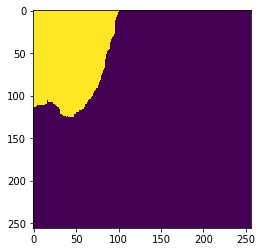

In [15]:
plt.imshow(((preds[16]/10)>0.5).astype(np.uint8))

In [16]:
p = [cv2.resize(o/10,dsize=(101,101)) for o in preds]
p = [(o>0.5).astype(np.uint8) for o in p]

In [17]:
pred_dict = {id_[11:-4]:RLenc(p[i]) for i,id_ in tqdm_notebook(enumerate(tst_x))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('simple_k_fold_flipped.csv')